In [2]:
# Cell 1

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.video.io.VideoFileClip import VideoFileClip
from scipy import misc

%matplotlib inline

In [3]:
# Cell 2

class Undistorter:
    def __init__(self):
        (mtx, dist) = Undistorter.calibrate_camera()
        self.mtx = mtx
        self.dist = dist

    @staticmethod
    def calibrate_camera():
        # size of the board: 10x7, but the code wants the corners
        width = 9
        height = 6

        images = glob.glob("camera_cal/calibration*.jpg")

        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image space

        # Prepare obj points
        objp = np.zeros((width*height, 3), np.float32)
        objp[:,:2] = np.mgrid[0:width,0:height].T.reshape(-1,2) # x,y coordinates

        shape = None

        for fname in images:

            # Read in the image in RGB
            img = mpimg.imread(fname)

            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            shape = gray.shape[::-1]

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (width, height), None)

            # If corners are found, collect them
            if ret == True:
                imgpoints.append(corners)
                objpoints.append(objp)

                # Draw and display the corners
                img = cv2.drawChessboardCorners(img, (width, height), corners, ret)

        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
        return (mtx, dist)

    def undistort_img(self, img):
        undist = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        return undist
    
undistorter = Undistorter()

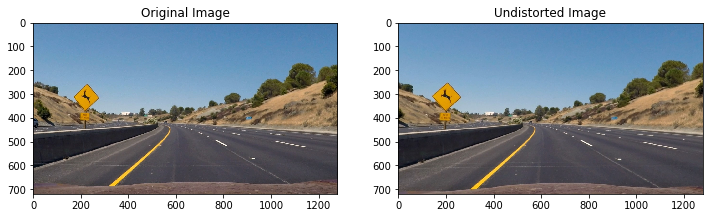

In [4]:
# Cell 3

def example_image_undistort(path):
    img = mpimg.imread(path)
    undist = undistorter.undistort_img(img)
    plt.figure(figsize=(12,9))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.title('Undistorted Image')
    plt.imshow(undist)
    
#example_image_undistort("camera_cal/calibration4.jpg")
example_image_undistort("test_images/test2.jpg")

In [5]:
# Cell 4

class Thresholder:
    
    def __init__(self, mag_thresh=(50, 255), dir_thresh=(0.7, 1.2), s_thresh=(170, 255)):
        self.mag_thresh = mag_thresh
        self.dir_thresh = dir_thresh
        self.s_thresh = s_thresh
    
    def thresholded_binary_image(self, undistorted):
        sobel_kernel = 3
        # Convert to grayscale
        gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)
        # Take both Sobel x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

        mag_binary = self.__mag_thresh(sobelx, sobely)
        dir_binary = self.__dir_threshold(sobelx, sobely)
        color_binary = self.__color_threshold(undistorted)

        combined = np.zeros_like(dir_binary)
        combined[((color_binary == 1) & ((mag_binary == 1) | (dir_binary == 1)))] = 1
        return combined
    
    def __mag_thresh(self, sobelx, sobely):
        # Calculate the gradient magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        # Rescale to 8 bit
        scale_factor = np.max(gradmag)/255 
        gradmag = (gradmag/scale_factor).astype(np.uint8) 
        # Create a binary image of ones where threshold is met, zeros otherwise
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= self.mag_thresh[0]) & (gradmag <= self.mag_thresh[1])] = 1
        return binary_output

    # Define a function to threshold an image for a given range and Sobel kernel
    def __dir_threshold(self, sobelx, sobely):
        # Take the absolute value of the gradient direction, 
        # apply a threshold, and create a binary image result
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        binary_output =  np.zeros_like(absgraddir)
        binary_output[(absgraddir >= self.dir_thresh[0]) & (absgraddir <= self.dir_thresh[1])] = 1
        return binary_output

    def __color_threshold(self, img):
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

        # white color mask - select pretty high light values
        lower = np.uint8([  0, 200,   0])
        upper = np.uint8([255, 255, 255])
        white_mask = cv2.inRange(hls, lower, upper)
        # yellow color mask: select yellowish collors in hue, but only the light ones
        lower = np.uint8([ 10,   0, 100])
        upper = np.uint8([ 40, 255, 255])
        yellow_mask = cv2.inRange(hls, lower, upper)
        # combine the mask
        binary_output = np.zeros_like(img[:, :, 0])
        binary_output[((yellow_mask != 0) | (white_mask != 0))] = 1

        return binary_output

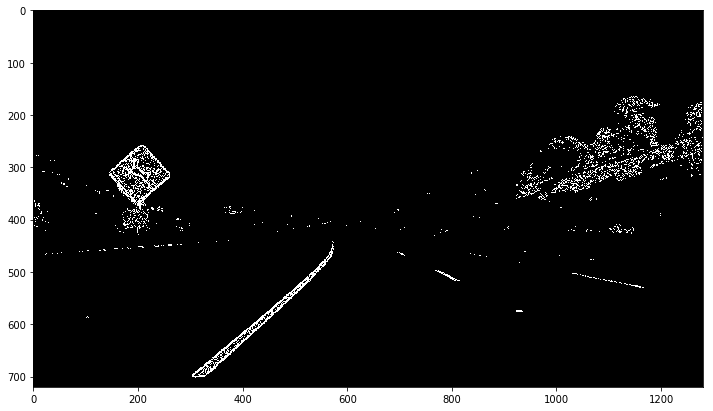

In [6]:
# Cell 5

def example_thresholded_binary_image():
    img = mpimg.imread("test_images/test2.jpg")
    undist = undistorter.undistort_img(img)
    plt.figure(figsize=(12,9))
    plt.imshow(Thresholder().thresholded_binary_image(undist), cmap='gray')
    
example_thresholded_binary_image()

In [7]:
# Cell 6

class Warper:
    def __init__(self, img_height, img_width):
        self.img_size = (img_width, img_height)
        self.src = np.float32(
            [[(img_width / 2) - 55, img_height / 2 + 100],
            [((img_width / 6) - 10), img_height],
            [(img_width * 5 / 6) + 60, img_height],
            [(img_width / 2 + 55), img_height / 2 + 100]])
        self.dst = np.float32(
            [[(img_width / 4), 0],
            [(img_width / 4), img_height],
            [(img_width * 3 / 4), img_height],
            [(img_width * 3 / 4), 0]])
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.Minv = cv2.getPerspectiveTransform(self.dst, self.src)

    def warp(self, img):
        return cv2.warpPerspective(img, self.M, self.img_size, flags=cv2.INTER_LINEAR)
    
    def unwarp(self, img):
        return cv2.warpPerspective(img, self.Minv, self.img_size, flags=cv2.INTER_LINEAR)

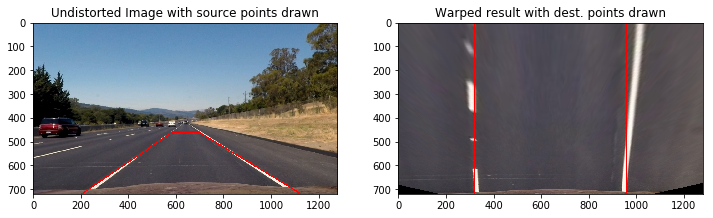

In [8]:
# Cell 7

def example_warped_image():
    img = mpimg.imread("test_images/straight_lines2.jpg")
    undist = undistorter.undistort_img(img)
    warper = Warper(img.shape[0], img.shape[1])
    warped = warper.warp(undist)
    
    src = warper.src
    dst = warper.dst
    
    pts = dst.astype(np.int32)
    pts = pts.reshape((-1,1,2))
    cv2.polylines(warped,[pts],True,(255,0,0),3)
    
    pts = src.astype(np.int32)
    pts = pts.reshape((-1,1,2))
    cv2.polylines(undist,[pts],True,(255,0,0),3)
    
    plt.figure(figsize=(12,9))
    plt.subplot(1, 2, 1)
    plt.title('Undistorted Image with source points drawn')
    plt.imshow(undist)
    plt.subplot(1, 2, 2)
    plt.title('Warped result with dest. points drawn')
    plt.imshow(warped)
    
example_warped_image()

In [ ]:
# Cell 8

class Polyfit:
    
    def __init__(self):
        self.left_fit = None
        self.right_fit = None
    
    def polyfit(self, binary_warped):
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        
        return (self.left_fit, self.right_fit)

class PolyfitDrawer:
    def draw(self, warper, undist, warped, left_fit, right_fit):
        # Generate x and y values for plotting
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
        
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = warper.unwarp(color_warp)
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
        
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
        leftx = left_fitx[::-1]  # Reverse to match top-to-bottom in y
        rightx = right_fitx[::-1]  # Reverse to match top-to-bottom in y
        y_eval = np.max(ploty)

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        
        curve = (left_curverad + right_curverad) / 2
        
        cv2.putText(result,"Lane curve: {}m".format(curve), (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1,
                color=(255, 255, 255), thickness=2)
        
        # Just apply the polyfit at the bottom of the image
        lane_leftx = left_fit[0] * (img.shape[0] - 1) ** 2 + left_fit[1] * (img.shape[0] - 1) + left_fit[2]
        lane_rightx = right_fit[0] * (img.shape[0] - 1) ** 2 + right_fit[1] * (img.shape[0] - 1) + right_fit[2]

        car_pos = ((img.shape[1] / 2) - ((lane_leftx + lane_rightx) / 2)) * xm_per_pix
        cv2.putText(result,"Car position: {}m".format(car_pos.round(2)), (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1,
                    color=(255, 255, 255), thickness=2)
        
        return result

In [ ]:
# Cell 9

def example_polyfit_image():
    img = mpimg.imread("test_images/test2.jpg")
    undist = undistorter.undistort_img(img)
    binary = Thresholder().thresholded_binary_image(undist);
    warper = Warper(img.shape[0], img.shape[1])
    binary_warped = warper.warp(binary) 
    
    (left_fit, right_fit) = Polyfit().polyfit(binary_warped)
    
    fit_lines = PolyfitDrawer().draw(warper, undist, binary_warped, left_fit, right_fit)
    
    plt.figure(figsize=(12,9))
    plt.imshow(fit_lines)

example_polyfit_image()

In [ ]:
# Cell 10

class Pipeline:
    def __init__(self, video_path):
        self.video_path = video_path
        self.video = VideoFileClip('{}.mp4'.format(video_path))
        self.undistorter = undistorter
        self.thresholder = Thresholder()
        self.warper = Warper(self.video.size[1], self.video.size[0])
        self.polyfitter = Polyfit()
        self.polyfit_drawer = PolyfitDrawer()

    def process_video(self):
        output = '{}_result.mp4'.format(self.video_path)
        #clip1 = self.video.subclip(41, 42)
        clip1 = self.video
        output_clip = clip1.fl_image(self.__process_image)
        output_clip.write_videofile(output, audio=False)
        
    def __process_image(self, img):
        
        misc.imsave('output_images/original.jpg', img)
        
        undist = self.undistorter.undistort_img(img)
        misc.imsave('output_images/undistorted.jpg', undist)

        binary = self.thresholder.thresholded_binary_image(undist);
        misc.imsave('output_images/thresholded.jpg', binary*255)
        
        binary_warped = self.warper.warp(binary) 
        misc.imsave('output_images/warped.jpg', binary_warped*255)

        (left_fit, right_fit) = self.polyfitter.polyfit(binary_warped)

        fit_lines = self.polyfit_drawer.draw(self.warper, undist, binary_warped, left_fit, right_fit)
        misc.imsave('output_images/final.jpg', fit_lines)
        
        return fit_lines 
        
# pipeline = Pipeline('harder_challenge_video')
# pipeline = Pipeline('challenge_video')
pipeline = Pipeline('project_video')
pipeline.process_video()